In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import exp
from scipy import ndimage
from PMASfunc import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile

In [2]:
def moffat_fit(data,error,box_size,amp,x0,y0,gamma_fixed=None,alpha_fixed=None,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size] 
    if gamma_fixed is None and alpha_fixed is None:
        p_init = models.Moffat2D(amplitude=amp,x_0=x0,y_0=y0,gamma=1,alpha=1)
    else:
        p_init = models.Moffat2D(amp,x0,y0,gamma_fixed,alpha_fixed,fixed={'gamma':True,'alpha':True})
    f = fitting.LevMarLSQFitter()
    p = f(p_init, x, y, data)
    model = p(x,y)
    residual = data - model
    res = (residual/error)
    [amp_out,x0_out,y0_out,gamma_out,alpha_out]= p.parameters
    fwhm_out = 2*gamma_out*np.sqrt(2**(1/alpha_out)-1)
    p_parameters = np.append(p.parameters,fwhm_out)
    parameters_MC = np.zeros((len(p_parameters),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if gamma_fixed is None and alpha_fixed is None:
            p_MC_init = models.Moffat2D(amplitude=amp,x_0=x0,y_0=y0,gamma=1,alpha=1)
        else:
            p_MC_init = models.Moffat2D(amp,x0,y0,gamma_fixed,alpha_fixed,fixed={'gamma':True,'alpha':True})
        f = fitting.LevMarLSQFitter()
        p_MC = f(p_MC_init, x, y, iteration_data)
        [amp_MC,x0_MC,y0_MC,gamma_MC,alpha_MC]= p_MC.parameters
        fwhm_MC = 2*gamma_MC*np.sqrt(2**(1/alpha_MC)-1)
        p_MC_parameters = np.append(p_MC.parameters, fwhm_MC)
        parameters_MC[:,l] = p_MC_parameters    
    parameters_err = np.std(parameters_MC,1) 
    [amp_err,x0_err,y0_err,gamma_err,alpha_err,fwhm_err] = parameters_err    
    if gamma_fixed is None and alpha_fixed is None:
        (par,err) = ([amp_out,x0_out,y0_out,gamma_out,alpha_out,fwhm_out],[amp_err,x0_err,y0_err,gamma_err,alpha_err,fwhm_err])   
    else:
        (par,err) = ([amp_out,x0_out,y0_out],[amp_err,x0_err,y0_err])   
    return par,err,model,res

def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_dev,OIII_br_dev,OIII_nr_dev,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_dev,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_dev,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_dev,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/13_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')
    
def moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'gamma':3,'alpha':4,'fwhm':5,'amp_OIII_br':6,'x0_OIII_br':7,'y0_OIII_br':8,'amp_OIII_nr':9,'x0_OIII_nr':10,'y0_OIII_nr':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/13_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_13_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_13_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_13_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_13_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_13_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_13_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [3]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    hdu = fits.open('%s/Flux Maps/%s/13_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/13_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_13_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2,emp_wing) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0],central_tab.field('emp_fact_wing')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_wing*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [4]:
def emp_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    hdu = fits.open('%s/Flux Maps/%s/13_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/13_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_13_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2,emp_wing) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0],central_tab.field('emp_fact_wing')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    return emp_Hb_blr,emp_wing    

In [10]:
def chi_squared(data,model,err):
    res = data - model
    a = np.sum((res/err)**2)
    return a

def red_chi_squared(data,res,n_free):
    dof = len(data.flatten()) - n_free
    k = res
    k[k>10**10]=0
    l = k[k!=0]
    a = np.sum(l**2)
    red = a/dof
    return red


In [11]:
def circular_moffat2D(x,y,amp,x0,y0,gamma,alpha):
    A = (1/gamma)**2 
    g = amp*((1.0+A*((x-x0)**2)+A*((y-y0)**2))**(-alpha))
    return g

def OIII_br_full_par(Hb_par,Hb_err,OIII_br_par,OIII_br_err):
    (gamma,alpha) = (Hb_par[3],Hb_par[4])
    (gamma_err,alpha_err) = (Hb_err[3],Hb_err[4])
    [amp,x0,y0] = OIII_br_par
    [amp_err,x0_err,y0_err] = OIII_br_err
    wing_full_par = [amp,x0,y0,gamma,alpha]
    wing_full_err = [amp_err,x0_err,y0_err,gamma_err,alpha_err]
    return wing_full_par,wing_full_err

def flux_ratio_err(data,error,par,par_err,box_size):
    [amp,x0,y0,gamma,alpha] = par
    [amp_err,x0_err,y0_err,gamma_err,alpha_err] = par_err
    dat1 = np.sum(data)
    err1 = np.sqrt(np.sum(error**2))
    MC_loops = 10
    ratio = np.zeros(MC_loops)
    
    for m in range(MC_loops):
        flux_aperture = np.random.normal(dat1,err1)
        y, x = np.mgrid[:box_size,:box_size]
        PSF = circular_moffat2D(x,y,np.random.normal(amp,amp_err),np.random.normal(x0,x0_err),np.random.normal(y0,y0_err),np.random.normal(gamma,gamma_err),np.random.normal(alpha,alpha_err))
        #plt.imshow(PSF)
        #plt.show()
        flux_PSF = np.sum(PSF)
        flux_ratio = flux_aperture/flux_PSF
        ratio[m] = flux_ratio
    ratio_err = np.nanstd(ratio)
    return ratio_err


In [16]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):  
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    (emp_blr,emp_wing) = emp_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]
    #print box_size   
    
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    #print (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y)
    (Hb_par,Hb_error,Hb_model,Hb_res) = moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,None,None,100)
    #print (Hb_par,Hb_error)
  
    #red_chi_sq_Hb = red_chi_squared(Hb_blr_br_data,Hb_model,Hb_blr_br_err,5)
    
    (gamma_fix,alpha_fix) = (Hb_par[3],Hb_par[4])#these two are gamma and alpha
    #print Hb_par
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,gamma_fix,alpha_fix,100)   
    #print (OIII_br_par,OIII_br_error)
    #red_chi_sq_wing = red_chi_squared(OIII_br_data,OIII_br_model,OIII_br_err,3)
    #norm_chi_sq_wing = red_chi_sq_wing/red_chi_sq_Hb
    
    #print (red_chi_sq_Hb,red_chi_sq_wing)
    
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,gamma_fix,alpha_fix,100)
    #print (OIII_nr_par,OIII_nr_error)

    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    
    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    
    moffat_table(full_data,full_error,obj)   
    red_chi_squared_Hb = red_chi_squared(Hb_blr_br_data,Hb_res,5)
    red_chi_squared_OIII_br = red_chi_squared(OIII_br_data,OIII_br_res,3)
    red_chi_squared_OIII_nr = red_chi_squared(OIII_nr_data,OIII_nr_res,3)
    normalized_chi_squared_OIII_br = (red_chi_squared_OIII_br/red_chi_squared_Hb)
    normalized_chi_squared_OIII_nr = (red_chi_squared_OIII_nr/red_chi_squared_Hb)
    
    flux_wing_data = np.sum(OIII_br_data)
    flux_wing_model = np.sum(OIII_br_model)
    flux_ratio = (flux_wing_data/flux_wing_model)
    plt.imshow(OIII_br_res,origin='lower',vmin=-5,vmax=5)
    plt.colorbar()
    plt.show()
    
    print (normalized_chi_squared_OIII_br,flux_ratio)    
    print ('%s.fits'%(obj))


1.7620504


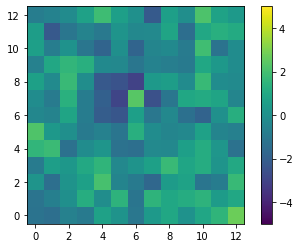

1.2540748266479353 1.0061397783184665
HE0853-0126.fits
1.2549138


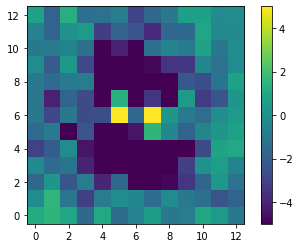

9.14190553827968 0.9312077551453392
HE0949-0122.fits


In [17]:
z = {"HE0853-0126":0.05981,"HE0949-0122":0.01993}

objs = z.keys()


for obj in objs:
    algorithm_script(obj,z[obj])

In [33]:
int(round(7.456))

7

In [17]:
import mpfit
import numpy as np
x = [2,3,1,0,9,0.7,8.6,199,67,54]
p0 = [5.7, 2.2, 500., 1.5, 2000.]
y = [223,3,11,0.3,99,7.7,88.6,1199,667,554]
err = [0.223,0.3,0.11,0.3,0.99,0.7,0.9,0.12,0.7,0.5]
fa = {'x':x, 'y':y, 'err':err}
m = mpfit('myfunct', p0, functkw=fa)
print ('status = ', m.status)
if (m.status <= 0):
    print ('error message = ', m.errmsg)
    print ('parameters = ', m.params)

TypeError: 'module' object is not callable

In [22]:
import pylab
import string
import math
import os
import sys
import time
import getopt
import numpy
import scipy.stats
import datetime
from math import sqrt
import mpfit

#
# append path
#
path=os.getcwd()
sys.path.append(path)
files = os.listdir(path)
#

def peval(x, p):
       # The model function with parameters p
       return (1./sqrt(2*numpy.pi*p[1]**2))*numpy.exp(-(x-p[0])**2/(2*p[1]**2))

def myfunct(p, fjac=None, x=None, y=None, err=None ):
       # Function that return the weighted deviates
       model = peval(x, p)
       status = 0
       return([status, (y-model)/err])

# Generate model data for a Gaussian with param mu and sigma and add noise
x=numpy.arange(-10.,10.,20./1000)
preal=[-2, .5]
y_true=peval(x,preal)
mu,sigma=0,0.7
y      = y_true + 0.06 * numpy.random.normal(mu,sigma, len(x) )
err    = 1.0 + 0.01 * numpy.random.normal(mu,sigma, len(x) )
# Initial estimates for MPFIT
p0 = [-0.5, 0.5]
fa = {'x':x, 'y':y, 'err':err}

# Call MPFIT with user defined function 'myfunct'
m = mpfit.mpfit( myfunct, p0, functkw=fa )

print ("status: ", m.status)
if (m.status <= 0): 
    print ('error message = ', m.errmsg)
else:
    print ("Iterations: ", m.niter)
    print ("Fitted pars: ", m.params)
    print ("Uncertainties: ", m.perror)

# Plot the result with Matplotlib
pylab.clf()
pylab.plot(x,y,'r', label="Noisy data")
pylab.plot( x,peval(x,m.params), label="Fit" )
pylab.plot( x,y_true, 'g', label="True data" )
pylab.xlabel( "X" )
pylab.ylabel( "Measurement data" )
pylab.title( "Least-squares fit to noisy data using MPFIT" )
pylab.legend()
pylab.show()

AttributeError: module 'mpfit' has no attribute 'mpfit'